In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules

# Ustawienia wyświetlania
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Notebook: segmentacja klientów i reguły asocjacyjne
- Wczytuje dane transakcyjne, czyści je i liczy cechy RFM per klient.
- Redukuje wymiary (PCA), klasteryzuje klientów (K-Means) i wizualizuje wyniki.
- Szuka produktów kupowanych razem (Apriori) na przykładzie transakcji z Francji.

# Krok 0: wczytanie i czyszczenie danych
- Wczytanie pliku OnlineRetail.csv (ISO-8859-1).
- Usunięcie braków CustomerID i zwrotów (Quantity > 0).
- Dodanie kolumny TotalSum i parsowanie InvoiceDate.

In [4]:
print("--- 0. Wczytywanie i czyszczenie danych ---")
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(f"Dane gotowe: {df.shape}")

--- 0. Wczytywanie i czyszczenie danych ---
Dane gotowe: (397924, 9)


# Krok 1: profil klienta RFM
- Oblicza Recency (dni od ostatniego zakupu), Frequency (liczba faktur) i Monetary (suma wydatków).
- Standaryzuje cechy, aby PCA i K-Means działały na porównywalnej skali.

In [6]:
# Profil klienta RFM (Recency, Frequency, Monetary)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_df = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})
customer_df.rename(columns={'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'Monetary'}, inplace=True)

# Standaryzacja cech dla algorytmów
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_df)
customer_scaled_df = pd.DataFrame(customer_scaled, columns=customer_df.columns)

# Krok 2: Grupa 1 — PCA
- Redukuje 3 cechy RFM do 2 komponentów głównych (PC1, PC2).
- Raportuje łączną wyjaśnioną wariancję, by ocenić utratę informacji.

In [7]:
print("\n--- Grupa 1: PCA (redukcja wymiarów) ---")
pca = PCA(n_components=2)
components = pca.fit_transform(customer_scaled_df)
pca_components = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
print("Wyjaśniona wariancja przez 2 komponenty:", pca.explained_variance_ratio_.sum())


--- Grupa 1: PCA (redukcja wymiarów) ---
Wyjaśniona wariancja przez 2 komponenty: 0.8106165569795445


# Krok 3: Grupa 2 — K-Means
- Klasteryzuje klientów na 3 segmenty w przestrzeni przeskalowanych RFM.
- Wizualizuje klastry na mapie PC1/PC2 oraz pokazuje średnie RFM per klaster.


--- Grupa 2: Klasteryzacja (K-Means) ---
Liczebność klastrów:
Cluster
0    3246
1    1080
2      13
Name: count, dtype: int64


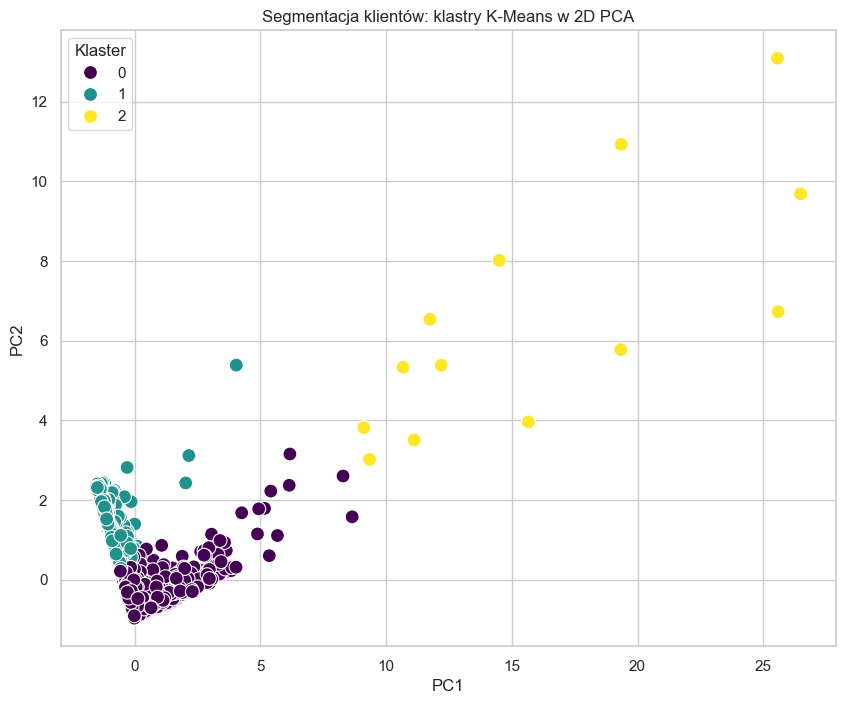


Średnie RFM w klastrach:
            Recency    Frequency       Monetary
Cluster                                        
0         41.368762   103.066235    2028.208836
1        247.308333    27.789815     637.318510
2          4.692308  2566.000000  126118.310000


In [9]:
print("\n--- Grupa 2: Klasteryzacja (K-Means) ---")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(customer_scaled_df)
customer_df['Cluster'] = clusters
print("Liczebność klastrów:")
print(customer_df['Cluster'].value_counts())

# Wizualizacja klastrów w przestrzeni PCA
pca_df = pca_components.copy()
pca_df['Cluster'] = clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Segmentacja klientów: klastry K-Means w 2D PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Klaster')
plt.show()

print("\nŚrednie RFM w klastrach:")
print(customer_df.groupby('Cluster').mean())

# Krok 4: Grupa 3 — reguły asocjacyjne (Apriori)
- Filtrowanie koszyków do Francji, binarizacja zakupów per produkt w fakturze.
- Apriori: częste zbiory (min_support=0.07), reguły z metryką lift i podgląd top 5.

In [11]:
print("\n--- Grupa 3: Reguły asocjacyjne (Apriori) ---")
basket_data = df[df['Country'] == 'France']
basket = (basket_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
print("Top 5 reguł (antecedent -> consequent):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


--- Grupa 3: Reguły asocjacyjne (Apriori) ---


C:\Users\blaze\AppData\Local\Temp\ipykernel_22156\1382870927.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)


Top 5 reguł (antecedent -> consequent):
                    antecedents                   consequents   support  \
0   (ALARM CLOCK BAKELIKE PINK)  (ALARM CLOCK BAKELIKE GREEN)  0.074550   
1  (ALARM CLOCK BAKELIKE GREEN)   (ALARM CLOCK BAKELIKE PINK)  0.074550   
2   (ALARM CLOCK BAKELIKE RED )  (ALARM CLOCK BAKELIKE GREEN)  0.079692   
3  (ALARM CLOCK BAKELIKE GREEN)   (ALARM CLOCK BAKELIKE RED )  0.079692   
4   (ALARM CLOCK BAKELIKE RED )   (ALARM CLOCK BAKELIKE PINK)  0.074550   

   confidence      lift  
0    0.725000  7.421711  
1    0.763158  7.421711  
2    0.837838  8.576814  
3    0.815789  8.576814  
4    0.783784  7.622297  


C:\Users\blaze\anaconda3\envs\lab_env\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
